# LangGraph Reducer 사용 예제

## LangGraph Reducer?
리듀서는 LangGraph에서 상태 업데이트 로직을 정의하는 핵심 메커니즘입니다. 각 노드가 반환하는 업데이트를 기존 상태에 어떻게 적용할지 결정하는 함수입니다.

## 왜 리듀서가 필요한가?

- 여러 노드가 동시에 또는 순차적으로 실행될 때, 각 노드의 출력을 상태에 통합하는 방법이 필요합니다. 
- 리듀서를 통해 누적, 병합, 최대값 유지 등 다양한 업데이트 전략을 구현할 수 있습니다.
- (**주의 사항으로 노드 병렬 실행시 리듀서를 적절히 사용하지 않으면 에러**)

* 출처 https://wikidocs.net/293355

In [ ]:
# 리듀서 없음 = 덮어쓰기 (Default Reducer)
old_state = {"counter": 5}
new_update = {"counter": 10}
result = {"counter": 10}  # 기존 값이 완전히 대체됨

# 리듀서 있음 = 사용자 정의 동작
from operator import add
old_state = {"items": [1, 2, 3]}
new_update = {"items": [4, 5]}
result = {"items": [1, 2, 3, 4, 5]}  # 리스트가 연결됨

In [ ]:
from typing_extensions import TypedDict

class SimpleState(TypedDict):
    counter: int          # 기본 리듀서: 덮어쓰기
    current_user: str     # 기본 리듀서: 덮어쓰기
    status: str          # 기본 리듀서: 덮어쓰기

def update_counter(state: SimpleState) -> SimpleState:
    """
    이 노드는 counter 값만 업데이트합니다.
    다른 키들(current_user, status)은 변경되지 않습니다.
    """
    return {"counter": state["counter"] + 1}  
    # 반환값: {"counter": 6} (state["counter"]가 5라면)
    # 최종 상태: 기존 상태에서 counter만 6으로 변경

def update_multiple(state: SimpleState) -> SimpleState:
    """
    여러 키를 동시에 업데이트할 수 있습니다.
    반환하지 않은 키는 그대로 유지됩니다.
    """
    return {
        "counter": 0,           # counter를 0으로 리셋
        "status": "completed"   # status를 "completed"로 변경
        # current_user는 언급하지 않았으므로 변경되지 않음
    }

# operator.add - 리스트/문자열 추가
- Python의 operator.add 함수를 활용한 누적 리듀서입니다.

In [42]:
# add 리듀서 실행 그래프

from operator import add
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class AddState(TypedDict):
    # Annotated[타입, 리듀서함수] 형식으로 리듀서 지정
    messages: Annotated[list[str], add]      # 리스트에 추가 ap
    log_text: Annotated[str, add]            # 문자열 연결

def add_message(state: AddState) -> AddState:
    """첫 번째 메시지 추가"""
    return {
        "messages": ["새 메시지"],              
        "log_text": "새 로그 항목\n"            
    }

def add_another_message(state: AddState) -> AddState:
    """두 번째 메시지 추가"""
    return {
        "messages": ["또 다른 메시지"],
        "log_text": "두 번째 로그\n"
    }

# 그래프 생성
builder = StateGraph(AddState)
builder.add_node("add_first", add_message)
builder.add_node("add_second", add_another_message)

# 간단한 순차 실행
builder.add_edge(START, "add_first")
builder.add_edge("add_first", "add_second")
builder.add_edge("add_second", END)

graph = builder.compile()

# 실행 테스트
initial_state = {
    "messages": ["안녕하세요"],
    "log_text": "시작\n"
}

print("=== add 리듀서 그래프 실행 ===")
result = graph.invoke(initial_state)

print("** 최종 결과 **")
print(f"messages: {result['messages']}")
print(f"log_text: {result['log_text']}")


=== add 리듀서 그래프 실행 ===
** 최종 결과 **
messages: ['안녕하세요', '새 메시지', '또 다른 메시지']
log_text: 시작
새 로그 항목
두 번째 로그



# 메시지 전용 리듀서 - add_messages
LangChain 메시지 객체를 위한 특별한 리듀서입니다.

In [ ]:
# add_messages 리듀서 채팅 그래프

from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from typing import Annotated
from typing_extensions import TypedDict

class ChatState(TypedDict):
    messages: Annotated[list, add_messages]  # 메시지 전용 리듀서

# class ChatState(MessagesState):
#     """MessagesState를 상속받으면 messages 필드와 add_messages 리듀서가 자동 포함"""

def generate_ai_response(state: ChatState) -> ChatState:
    """AI 응답 생성 노드"""
    return {
        "messages": [AIMessage(content="안녕하세요! 오늘 날씨는 맑음 입니다.")]
    }

# 그래프 생성
builder = StateGraph(ChatState)
builder.add_node("ai_response", generate_ai_response)

# 간단한 순차 실행
builder.add_edge(START, "ai_response")
builder.add_edge("ai_response", END)

chat_graph = builder.compile()

# 실행 테스트
initial_state = {
    "messages": [HumanMessage(content="안녕하세요! 오늘 날씨는 어떤가요?")]
}

print("=== add_messages 리듀서 채팅 그래프 실행 ===")
result = chat_graph.invoke(initial_state)

print("\n=== 최종 메시지 목록 ===")
for i, msg in enumerate(result["messages"]):
    print(f"{i+1}. {msg.__class__.__name__}: {msg.content}")


=== add_messages 리듀서 채팅 그래프 실행 ===

=== 최종 메시지 목록 ===
1. HumanMessage: 안녕하세요! 오늘 날씨는 어떤가요?
2. AIMessage: 안녕하세요! 오늘 날씨는 맑음 입니다.


# 단순한 사용자 정의 리듀서
- 특정 비즈니스 로직을 구현하는 리듀서를 만들 수 있습니다.

In [ ]:
def max_reducer(existing: int, new: int) -> int:
    """
    더 큰 값을 유지하는 리듀서
    """
    return max(existing or 0, new or 0)

class MaxState(TypedDict):
    highest_score: Annotated[int, max_reducer]
    current_score: int  # 리듀서 없음 (덮어쓰기)


In [41]:

class MaxState(TypedDict):
    highest_score: Annotated[int, max_reducer]  # 커스텀 리듀서 사용
    current_score: int  # 리듀서 없음 (덮어쓰기)

def update_score_1(state: MaxState) -> MaxState:
    """첫 번째 점수 업데이트"""
    new_score = 92
    print(f"노드1: {new_score}점 업데이트 시도")
    return {
        "highest_score": new_score,  # max_reducer가 적용됨
        "current_score": new_score   # 단순 덮어쓰기
    }

def update_score_2(state: MaxState) -> MaxState:
    """두 번째 점수 업데이트"""
    new_score = 85
    print(f"노드2: {new_score}점 업데이트 시도")
    return {
        "highest_score": new_score,  # max_reducer가 적용됨
        "current_score": new_score   # 단순 덮어쓰기
    }

# 그래프 생성
builder = StateGraph(MaxState)
builder.add_node("score_update_1", update_score_1)
builder.add_node("score_update_2", update_score_2)

# 순차 실행
builder.add_edge(START, "score_update_1")
builder.add_edge("score_update_1", "score_update_2")
builder.add_edge("score_update_2", END)

score_graph = builder.compile()

# 실행 테스트
initial_state = {
    "highest_score": 90,  # 초기 최고 점수
    "current_score": 90   # 초기 현재 점수
}

print("=== max_reducer 커스텀 리듀서 그래프 실행 ===")
print(f"초기 상태: {initial_state}")

result = score_graph.invoke(initial_state)

print(f"\n최종 결과:")
print(f"highest_score: {result['highest_score']} (max_reducer 적용)")
print(f"current_score: {result['current_score']} (덮어쓰기)")


=== max_reducer 커스텀 리듀서 그래프 실행 ===
초기 상태: {'highest_score': 90, 'current_score': 90}
노드1: 92점 업데이트 시도
노드2: 85점 업데이트 시도

최종 결과:
highest_score: 92 (max_reducer 적용)
current_score: 85 (덮어쓰기)


# 리듀서를 사용하지 않으면 에러나는 경우 
- 2개 이상의 병렬 노드에서 동시에 하나의 상태값을 업데이트 할 때 리듀서를 적용하지 않으면 에러
- LangGraph에서 정의하고 있는 병합 규칙사용해야 한다.

In [ ]:
# 쿼리 재작성 예제 - 병렬 노드 구조

from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 상태 정의 - 쿼리와 재작성된 결과들을 저장
class QueryState(TypedDict):
    original_query: str
    rewritten_queries: Annotated[list, add_messages]
    # rewritten_queries: list
    final_result: str


# 노드 1
def formal_rewriter(state: QueryState) -> dict:
    """  공식적인 톤으로 쿼리 재작성 하는 노드 """ 
    original = state["original_query"]
    formal_version = f"[공식] {original}에 대해 상세히 설명해주세요."
    print(f"공식적 재작성: {formal_version}")

    return {"rewritten_queries": [formal_version]}


# 노드 2
def casual_rewriter(state: QueryState) -> dict:
    """ 친근한 톤으로 쿼리 재작성 하는 노드 """ 
    original = state["original_query"]
    casual_version = f"[친근] {original}이 뭔지 쉽게 알려줘!"
    print(f"친근한 재작성: {casual_version}")

    return {"rewritten_queries": [casual_version]}


# 노드 3
def result_combiner(state: QueryState) -> dict:
    """ 두 재작성 결과를 통합하는 노드 """ 
    queries = state["rewritten_queries"]
    combined = f"원본: {state['original_query']}\n재작성 결과:\n{queries}"
    print(f"통합 결과:\n{combined}")

    return {"final_result": combined}


# 상태 그래프 초기화
builder = StateGraph(QueryState)

# 노드 추가
builder.add_node("formal_rewriter", formal_rewriter)
builder.add_node("casual_rewriter", casual_rewriter) 
builder.add_node("result_combiner", result_combiner)

# 그래프 연결 - 병렬 실행 후 통합
builder.add_edge(START, "formal_rewriter")
builder.add_edge(START, "casual_rewriter")
builder.add_edge(["formal_rewriter", "casual_rewriter"], "result_combiner")
builder.add_edge("result_combiner", END)

# 그래프 컴파일
query_rewriter_graph = builder.compile()


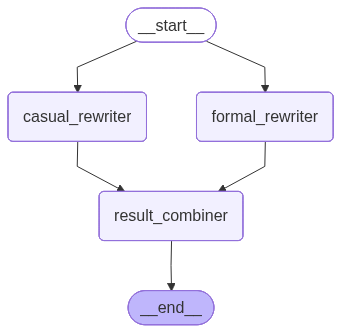

In [69]:
from IPython.display import Image, display

display(Image(query_rewriter_graph.get_graph().draw_mermaid_png()))

In [70]:
# 그래프 실행 테스트
initial_state = {
    "original_query": "파이썬이 뭐야?",
    "rewritten_queries": [],
    "final_result": ""
}

print("=== 쿼리 재작성 그래프 실행 ===")
result = query_rewriter_graph.invoke(initial_state)

print("\n=== 최종 결과 ===")
print(result["final_result"])


=== 쿼리 재작성 그래프 실행 ===
친근한 재작성: [친근] 파이썬이 뭐야?이 뭔지 쉽게 알려줘!
공식적 재작성: [공식] 파이썬이 뭐야?에 대해 상세히 설명해주세요.
통합 결과:
원본: 파이썬이 뭐야?
재작성 결과:
['[친근] 파이썬이 뭐야?이 뭔지 쉽게 알려줘!']

=== 최종 결과 ===
원본: 파이썬이 뭐야?
재작성 결과:
['[친근] 파이썬이 뭐야?이 뭔지 쉽게 알려줘!']


# 스레드간 영속성
- 공원나연 강의에서 한 스레드(thread_id) 내 에서는 이전 대화를 기억해 멀티턴이 가능하다고 언급, 특정 스레드 간에 대화 내용을 기억할 수는 없을까?
- 공유 메모리(store) 활용하여 여러 스레드 간 기억을 저장할 수 있다.
- 예를 들어, 사용자의 이름이나 선호도와 같은 정보를 공유 메모리에 저장하고 새로운 대화 스레드에서 재사용할 수 있다.


- Store 인터페이스를 사용하여 객체를 저장할 때 두 가지를 정의해야 한다.
1. 객체의 네임스페이스, 튜플(디렉토리와 유사)
2. 객체 키(파일명과 유사)

* 주의: 프로세스를 중단하면 Store 내 모든 정보 삭제됨, 기억을 유지하기 위해서는 postgreStore 사용 가능(https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#use-in-subgraphs)

*출처: https://rudaks.tistory.com/entry/langgraph-그래프에-여러-스레드-간-영속성을-추가하는-방법#google_vignette*



In [ ]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore

import uuid
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

load_dotenv(override=True)

in_memory_store = InMemoryStore()

model = ChatOpenAI(model="gpt-4o-mini")

# 참고: 노드에 Store 매개변수를 전달한다.
# 이는 그래프를 컴파일할 때 사용하는 Store이다.
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # 본 예제에서는 네임스페이스로 ("memories", <user_id>)를 사용하고, 각 새로운 메모리에 대해 랜덤 UUID를 키로 사용한다.
    user_id = config["configurable"]["user_id"]      # 유저 아이디
    namespace = ("memories", user_id)                # 네임스페이스 (유저 아이디 포함)

    # 사용자가 모델에게 기억하라고 요청하면 새로운 기억을 저장한다.
    last_message = state["messages"][-1]
    if "기억해" in last_message.content.lower():
        memory = last_message.content
        store.put(namespace, str(uuid.uuid4()), {"data": memory})

    # 네임 스페이스 사용하여 기억 검색
    memories = store.search(namespace)     
    # 기억 정보 조합
    info = "\n".join([d.value["data"] for d in memories])  
    system_msg = f"You are a helpful assistant talking to the user. User info: {info}"

    response = model.invoke(
        [{"type": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}


builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

# 참고: 그래프를 컴파일할 때 Store 객체를 전달한다.
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)


## 그래프 실행

In [59]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_message = {"type": "user", "content": "안녕. 기억해. 이름은 홍길동 나이는 30살"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()




================================ Human Message =================================

안녕. 기억해. 이름은 홍길동 나이는 30살
================================== Ai Message ==================================

안녕하세요, 홍길동님! 만나서 반갑습니다. 도움이 필요하신 부분이나 궁금한 점이 있으신가요?


In [60]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}
input_message = {"type": "user", "content": "내 나이는?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

내 나이는?
================================== Ai Message ==================================

당신의 나이는 30살입니다. 기억하고 있습니다!


In [61]:
for memory in in_memory_store.search(("memories", "1")):
    print(memory.value)


{'data': '안녕. 기억해. 이름은 홍길동 나이는 30살'}


In [64]:
config = {"configurable": {"thread_id": "3", "user_id": "2"}}
input_message = {"type": "user", "content": "내 나이가 몇살이야?"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

내 나이가 몇살이야?
================================== Ai Message ==================================

죄송하지만, 당신의 나이를 알 수 있는 정보가 없어요. 태어난 연도를 알려주시면 나이를 계산해드릴 수 있어요!
